In [16]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
using LinearAlgebra
using StaticArrays

using LinearAlgebra

###############################################################################
# Constants
###############################################################################
const R_EARTH = 6378.137  # approximate Earth radius in km

###############################################################################
# Basic geometry helpers
###############################################################################

"Return rotation matrix about local X-axis by angle θ."
function rotX(θ)
    c, s = cos(θ), sin(θ)
    return Matrix([
        1.0  0.0  0.0
        0.0   c   -s
        0.0   s    c
    ])
end

"Return rotation matrix about local Y-axis by angle θ."
function rotY(θ)
    c, s = cos(θ), sin(θ)
    return Matrix([
         c   0.0    s
        0.0  1.0   0.0
        -s   0.0    c
    ])
end

"Convert (lat, lon) in radians + radius to ECEF [x, y, z]."
function latlon_to_ecef(lat::Float64, lon::Float64, r::Float64)
    x = r * cos(lat) * cos(lon)
    y = r * cos(lat) * sin(lon)
    z = r * sin(lat)
    return [x, y, z]
end

"""
    ecef_to_latlon(pos::Vector{Float64}) -> (lat, lon)

Convert ECEF [x, y, z] to spherical (lat, lon) in radians.
"""
function ecef_to_latlon(pos::Vector{Float64})
    x, y, z = pos
    r_xy = sqrt(x^2 + y^2)
    lat  = atan(z, r_xy)
    lon  = atan(y, x)
    return (lat, lon)
end

"""
    build_enu(lat0, lon0) -> (e, n, u)

Build local East, North, Up vectors (each length=1) at lat0, lon0 (radians).
These are expressed in ECEF coordinates.
"""
function build_enu(lat0::Float64, lon0::Float64)
    # Up (zenith)
    u = [cos(lat0)*cos(lon0),
         cos(lat0)*sin(lon0),
         sin(lat0)]
    # East
    e = [-sin(lon0),
          cos(lon0),
          0.0]
    # North
    n = cross(u, e)  # or cross(e, u), depending on sign
    return (e, n, u)
end

"""
    footprint_extents_spherical(lat0, lon0, h, pitch, roll, alpha; R=R_EARTH, N=180)

Compute the bounding-box footprint dimensions in the local East and North
directions for a circular sensor half-angle `alpha`, from altitude `h` above
a spherical Earth of radius `R`. The satellite is at (lat0, lon0).

Angles (pitch, roll, alpha) in radians.  `N` is how many azimuth steps around
the cone to sample. Returns (width_across, width_along) in the same units as R,h.

- `pitch` is rotation about local x (East), so +pitch tilts sensor forward/back along track (northbound).
- `roll`  is rotation about local y (North), so +roll tilts sensor left/right across track.
- The result accounts for Earth curvature.  A forward pitch can stretch the
  across-track width, etc.
"""
function footprint_extents_spherical(lat0, lon0, h, pitch, roll, alpha; R=R_EARTH, N=180)

    # 1) Satellite position in ECEF:
    sat_ecef = latlon_to_ecef(lat0, lon0, R + h)

    # 2) Sub-satellite point on Earth surface (radius=R)
    subsat_ecef = latlon_to_ecef(lat0, lon0, R)

    # 3) Local axes (e, n, u) in ECEF
    ê, n̂, û = build_enu(lat0, lon0)

    # 4) Boresight in local (ENU) coords: start with (0,0,-1) = "nadir"
    v_local_nadir = [0.0, 0.0, -1.0]

    #    Apply roll about X, then pitch about Y:
    #    (If your pitch/roll definitions differ, reorder these calls.)
    rot_local = rotY(pitch) * rotX(roll)
    v_local_boresight = rot_local * v_local_nadir  # in local ENU coords

    # 5) Convert that boresight into ECEF by linear combo of (e, n, u)
    v_b = v_local_boresight[1]*ê +
          v_local_boresight[2]*n̂ +
          v_local_boresight[3]*û
    v_b = normalize(v_b)  # just to be safe

    # 6) Build orthonormal vectors e1, e2 perpendicular to v_b (for the cone)
    #    We'll pick e1 = (v_b × û) × v_b as a "horizontal" vector,
    #    then e2 = v_b × e1.  There's some arbitrariness but that's ok.
    tmp = cross(v_b, û)
    if norm(tmp) < 1e-9
        # degenerate if v_b is near +/- up.  fallback to cross with ê
        tmp = cross(v_b, ê)
    end
    e1 = cross(tmp, v_b)
    e1 = e1 / norm(e1)
    e2 = cross(v_b, e1)
    e2 = e2 / norm(e2)

    # We'll sample directions around the cone using phi in [0, 2π).
    phivals = range(0, 2π, length=N+1)[1:end-1]

    e_vals = Float64[]
    n_vals = Float64[]

    # Ray-sphere intersection function:
    # X(t) = sat_ecef + t*v_dir,  want ||X(t)||=R => solve quadratic
    function intersect_earth(sat::Vector{Float64}, dir::Vector{Float64}, R::Float64)
        # Solve ||sat + t*dir||^2 = R^2
        S, V = sat, dir
        SdotS = dot(S,S)
        SdotV = dot(S,V)
        VdotV = dot(V,V)
        a = VdotV
        b = 2*SdotV
        c = SdotS - R^2
        disc = b^2 - 4a*c
        if disc < 0
            return nothing  # no real intersection
        end
        sqrt_disc = sqrt(disc)
        t1 = (-b + sqrt_disc)/(2a)
        t2 = (-b - sqrt_disc)/(2a)
        # We want the solution that is physically "below" the satellite.
        # Usually, if dir is downward, t might be negative. So let's pick the
        # one that yields a smaller |sat + t*dir - sat|.  i.e. the one
        # that is closest to sat along the correct direction.
        t_candidates = [t1, t2]
        # filter out NaNs
        t_candidates = filter(!isnan, t_candidates)
        if isempty(t_candidates)
            return nothing
        end
        # pick whichever has minimal distance to the satellite
        distfun(t) = norm(S + t*V - S)
        t_best = t_candidates[argmin(distfun.(t_candidates))]
        return S + t_best*V
    end

    # 7) Loop over cone boundary:
    for φ in phivals
        # direction in ECEF for the cone's surface
        v_cone = v_b*cos(alpha) + e1*sin(alpha)*cos(φ) + e2*sin(alpha)*sin(φ)
        v_cone = normalize(v_cone)

        # Intersection:
        X_int = intersect_earth(sat_ecef, v_cone, R)
        if X_int === nothing
            continue
        end

        # Convert to local offsets from sub-satellite point:
        dx = X_int .- subsat_ecef
        e_ = dot(dx, ê)
        n_ = dot(dx, n̂)

        push!(e_vals, e_)
        push!(n_vals, n_)
    end

    # 8) Compute bounding box in e/n
    dE = (isempty(e_vals)) ? 0.0 : (maximum(e_vals) - minimum(e_vals))
    dN = (isempty(n_vals)) ? 0.0 : (maximum(n_vals) - minimum(n_vals))

    return (dE*1000, dN*1000)
end



  Activating project at `~/code/gitHub/CarbonI`


footprint_extents_spherical

In [17]:
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
set_theme!(theme_ggplot2())

In [29]:
lat0_deg  = 0.0
lon0_deg  = 0.0
h_km      = 668.0
pitch_deg = 30.0
roll_deg  = 30.0


h_km = 668.0
pitch_deg = 0:38.0
roll_deg  = 0:10:50.0
iFOV_half = 51.7/1000000/2
pitch = deg2rad.(collect(pitch_deg));
roll = deg2rad.(collect(roll_deg));

#fs = computeFootprints.(pitch_deg, roll_deg');
fs = footprint_extents_spherical.(lat0, lon0, h_km, pitch, roll', iFOV_half;
                                                    R=R_EARTH, N=180);
                                                    
footprint_sizes = [a[2] for a in fs];
fs_nadir = footprint_extents_spherical(lat0, lon0, h_km, 0.0, 0.0, iFOV_half;
                                                    R=R_EARTH, N=180)[2];

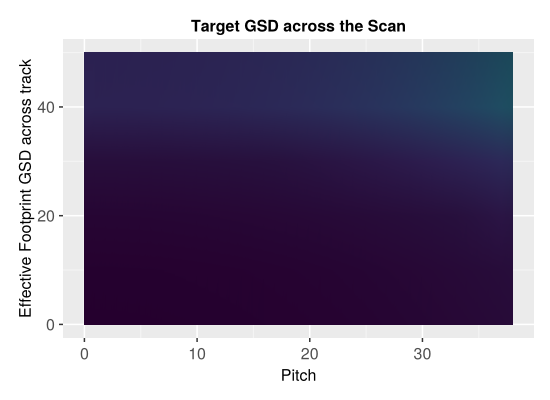

In [30]:
f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch", ylabel="Effective Footprint GSD across track",  title="Target GSD across the Scan")
surface!(ax, pitch_deg, roll_deg, footprint_sizes; colormap=:viridis,  colorbar=true)
#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")

#axislegend(ax,position = :lt;  labelsize=12)
#ylims!(ax, 0, 140)
f


pitch_deg[index] = 35.0


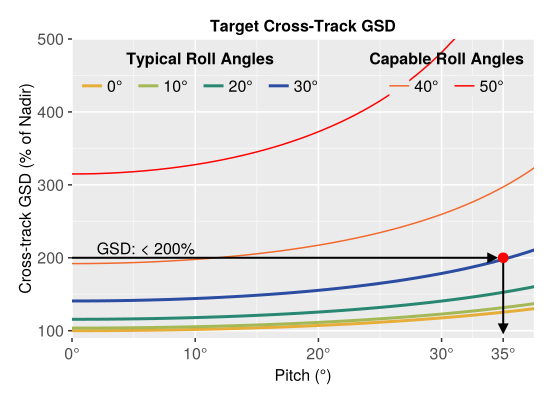

In [31]:
f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch (°)", ylabel="Cross-track GSD (% of Nadir)",  title="Target Cross-Track GSD", xticks=([0,10,20,30,35], ["0°", "10°", "20°", "30°", "35°"]))
sc1 = lines!(ax, pitch_deg , footprint_sizes[:,1]./fs_nadir*100, color=CarbonI_colors[1], linewidth=3,  label="Roll = 0°")
sc2 = lines!(ax, pitch_deg , footprint_sizes[:,2]./fs_nadir*100, color=CarbonI_colors[2], linewidth=3,  label="10°")
sc3 = lines!(ax, pitch_deg , footprint_sizes[:,3]./fs_nadir*100, color=CarbonI_colors[3], linewidth=3,  label="20°")
sc4 = lines!(ax, pitch_deg , footprint_sizes[:,4]./fs_nadir*100, color=CarbonI_colors[4], linewidth=3,  label="30°")
sc5 = lines!(ax, pitch_deg , footprint_sizes[:,5]./fs_nadir*100, color=CarbonI_colors[5], linewidth=1.5,  label="40°")
sc6 = lines!(ax, pitch_deg , footprint_sizes[:,6]./fs_nadir*100, color=:red, linewidth=1.5,  label="50°")

index = 36
req_gsd = 200

@show pitch_deg[index]

text!(ax, "GSD: < $(round(Int, req_gsd))%", position = (2, req_gsd),
    align = (:left, :bottom), color = :black)
arrows!(ax, [0,],[req_gsd,],[pitch_deg[index]-1.0,],[0,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
arrows!(ax, [pitch_deg[index],],[req_gsd],[0,],[-req_gsd+105,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
scatter!(ax, [pitch_deg[index]], [req_gsd], color=:red, markersize=15, label="Driving")
#lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")

#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")
axislegend(ax, [sc1, sc2,sc3,sc4], ["0°", "10°","20°","30°"], "Typical Roll Angles", position = :lt,
    orientation = :horizontal)
axislegend(ax, [sc5, sc6], ["40°", "50°"], "Capable Roll Angles", position = :rt,
    orientation = :horizontal)

ylims!(ax, 90, 500)
xlims!(ax, 0, 37.5)
save("../../plots/final/TargetGSDs.pdf",f)
f

pitch_deg[index] = 35.0


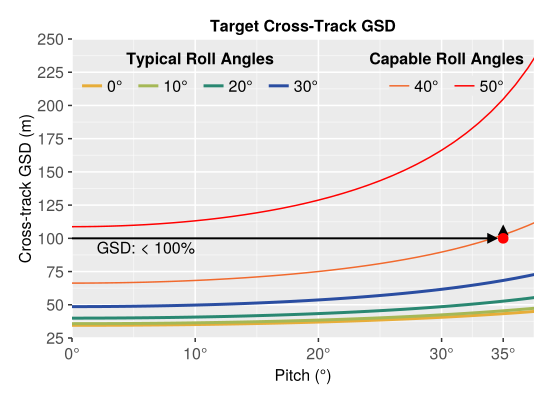

In [ ]:
f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch (°)", ylabel="Cross-track GSD (m)",  title="Target Cross-Track GSD", xticks=([0,10,20,30,35], ["0°", "10°", "20°", "30°", "35°"]))
sc1 = lines!(ax, pitch_deg , footprint_sizes[:,1], color=CarbonI_colors[1], linewidth=3,  label="Roll = 0°")
sc2 = lines!(ax, pitch_deg , footprint_sizes[:,2], color=CarbonI_colors[2], linewidth=3,  label="10°")
sc3 = lines!(ax, pitch_deg , footprint_sizes[:,3], color=CarbonI_colors[3], linewidth=3,  label="20°")
sc4 = lines!(ax, pitch_deg , footprint_sizes[:,4], color=CarbonI_colors[4], linewidth=3,  label="30°")
sc5 = lines!(ax, pitch_deg , footprint_sizes[:,5], color=CarbonI_colors[5], linewidth=1.5,  label="40°")
sc6 = lines!(ax, pitch_deg , footprint_sizes[:,6], color=:red, linewidth=1.5,  label="50°")

index = 36
req_gsd = 100

@show pitch_deg[index]

text!(ax, "GSD: < $(round(Int, req_gsd))m", position = (2, req_gsd),
    align = (:left, :top), color = :black)
arrows!(ax, [0,],[req_gsd,],[pitch_deg[index]-1.0,],[0,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
arrows!(ax, [pitch_deg[index],],[req_gsd],[0,],[-req_gsd+105,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
scatter!(ax, [pitch_deg[index]], [req_gsd], color=:red, markersize=15, label="Driving")
#lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")

#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")
axislegend(ax, [sc1, sc2,sc3,sc4], ["0°", "10°","20°","30°"], "Typical Roll Angles", position = :lt,
    orientation = :horizontal)
axislegend(ax, [sc5, sc6], ["40°", "50°"], "Capable Roll Angles", position = :rt,
    orientation = :horizontal)

ylims!(ax, 25, 250)
xlims!(ax, 0, 37.5)
save("../../plots/final/TargetGSDs_meters.pdf",f)
f